Блок с оптимизацией по историческим данным

In [233]:
# импорт библиотек

import yfinance as yf # для яху финансов
import requests # для парсинга с моекса
import pandas as pd # работа с данными
import numpy as np # работа с числами
import matplotlib.pyplot as plt # для визуалок
import seaborn as sns # для визуалок
from scipy.optimize import minimize # для оптимизации портфеля
from datetime import datetime # для работы с данными
from xgboost import XGBRegressor # для регрессии XGB Regressor
from prophet import Prophet # для регрессии Prophet
from sklearn.model_selection import train_test_split # для разделения данных
from sklearn.linear_model import LinearRegression # для расчета бета

In [234]:
# Единый конфиг (словарь)

config = {
    "model": "XGBRegressor", # модель (Prophet или XGBRegressor)
    "tickers": ["SBER", "GAZP", "LKOH", "NVTK", "MGNT", "TATN", "ROSN", "RUAL", "T", "MOEX", "YDEX", "HHRU"], # тикеры "AAPL", "MSFT", "NVDA", "AMZN", "TSLA", "MA" / "SBER", "GAZP", "LKOH", "NVTK", "MGNT", "TATN"
    "bond_tickers": [],  # номера облигаций "SU29020RMFS3", "RU000A1094F2"
    "start_date": "2023-01-01",           # дата начала истории
    "end_date": "2025-05-12",             # дата конца истории
    "source": "moex",                     # выбор источника истории (moex или yfinance)
    "risk_free_rate": 0.15                # безрисковая ставка (15% для РФ / 5% для US)
}


In [235]:
# Загрузка данных из яху финансов по ценам закрытия в указанный период

def get_data_yfinance(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)["Close"]
    return data

In [236]:
# Загрузка данных с MOEX API с поддержкой постраничной загрузки

def get_data_moex(tickers, start, end):
    def load_one(ticker):
        all_pages = [] # здесь лежат страницы с данными
        start_index = 0 # номер первой страницы с которой начинается загрузка
        page_size = 100 # номер последней страницы после которой загрузка закончится (100 это условие использования бесплатной версии АПИ мосбиржи)

        while True:
            url = f"https://iss.moex.com/iss/history/engines/stock/markets/shares/boards/TQBR/securities/{ticker}.json"
            params = {
                "from": start,
                "till": end,
                "interval": 24, # одна строка для 24 часов, т.е. дневные данные
                "start": start_index
            }
            r = requests.get(url, params=params)
            json_data = r.json()

            cols = json_data["history"]["columns"] # названия столбцов
            rows = json_data["history"]["data"] # строки для этих столбцов

            if not rows: # условие что если данных нет, цикл загрузки завершается
                break

            df = pd.DataFrame(rows, columns=cols) # создание таблички из того что вытащили из апи 
            all_pages.append(df) # вставка данных в табличку

            if len(rows) < page_size: # если количество строчек меньше 100 то это последняя страница и 
                break

            start_index += page_size # надо старт сдвинуть на следующую старницу

        if not all_pages:
            return pd.DataFrame() # объединяем все странички

        df = pd.concat(all_pages, ignore_index=True)
        df = df[["TRADEDATE", "CLOSE"]].dropna() # оставляем только дату и цену закрытия
        df.columns = ["Date", ticker] 
        df["Date"] = pd.to_datetime(df["Date"]) 
        df.set_index("Date", inplace=True) # делаем дату индексом
        return df

    dfs = [load_one(t) for t in tickers] # вызываем все вышеописанное для каждого из тикеров
    df_all = pd.concat(dfs, axis=1).sort_index() # объединяем все по столбцам 
    return df_all # получаем табличку на выходе


In [237]:
def get_bond_data_moex(bond_tickers, start, end):
    boards_to_try = ["TQOB", "TQCB", "TQIR", "TQOD", "TQTE", "TQPI"]

    def get_bond_info(ticker):
        """Получаем номинал и дату начала торгов"""
        url = f"https://iss.moex.com/iss/securities/{ticker}.json"
        r = requests.get(url)
        if r.status_code == 200:
            data = r.json()
            facevalue = None
            start_date = None
            for row in data["description"]["data"]:
                if row[0] == "Номинал":
                    facevalue = float(row[1])  # Номинал в рублях
                elif row[0] == "Дата начала торгов":  # Исправлено: было row[1]
                    start_date = pd.to_datetime(row[1])  # Исправлено: было row[1]
            return facevalue, start_date
        return None, None

    def load_one_bond(ticker):
        facevalue, actual_start = get_bond_info(ticker)
        if not facevalue:
            facevalue = 1000.0  # Дефолтный номинал

        # Корректируем дату start для текущей облигации
        adjusted_start = start
        if actual_start and actual_start > pd.to_datetime(start):
            adjusted_start = actual_start.strftime("%Y-%m-%d")
            print(f"Для {ticker} дата старта торгов позже {start}. Используем {adjusted_start}.")

        # Загружаем данные порциями (пагинация)
        all_data = []
        start_record = 0
        batch_size = 100
        
        for board in boards_to_try:
            while True:
                url = f"https://iss.moex.com/iss/history/engines/stock/markets/bonds/boards/{board}/securities/{ticker}.json"
                params = {
                    "from": adjusted_start,
                    "till": end,
                    "start": start_record,
                    "limit": batch_size
                }
                r = requests.get(url, params=params)
                d = r.json()
                data = d["history"]["data"]
                
                if not data:
                    break
                    
                all_data.extend(data)
                start_record += batch_size

        if all_data:
            df = pd.DataFrame(all_data, columns=d["history"]["columns"])
            df = df[["TRADEDATE", "CLOSE"]].copy()
            df["TRADEDATE"] = pd.to_datetime(df["TRADEDATE"])
            df["CLOSE"] = df["CLOSE"] * facevalue / 100  # Конвертация % → рубли
            df.set_index("TRADEDATE", inplace=True)
            df.rename(columns={"CLOSE": ticker}, inplace=True)
            return df
            
        print(f"Данные отсутствуют для {ticker}")
        return pd.DataFrame()

    bond_frames = [load_one_bond(ticker) for ticker in bond_tickers]
    return pd.concat(bond_frames, axis=1).sort_index()

In [238]:
# Универсальный загрузчик акций и облигаций
def get_price_data(tickers, start, end, source="yfinance", bond_tickers=None):
    if source == "yfinance": 
        price_df = get_data_yfinance(tickers, start, end)
    elif source == "moex":
        price_df = get_data_moex(tickers, start, end)
        
        # Если переданы облигации — загружаем и объединяем
        if bond_tickers:
            bond_df = get_bond_data_moex(bond_tickers, start, end)
            price_df = pd.concat([price_df, bond_df], axis=1).sort_index()
    else:
        raise ValueError("Источник должен быть 'yfinance' или 'moex'")
    
    return price_df

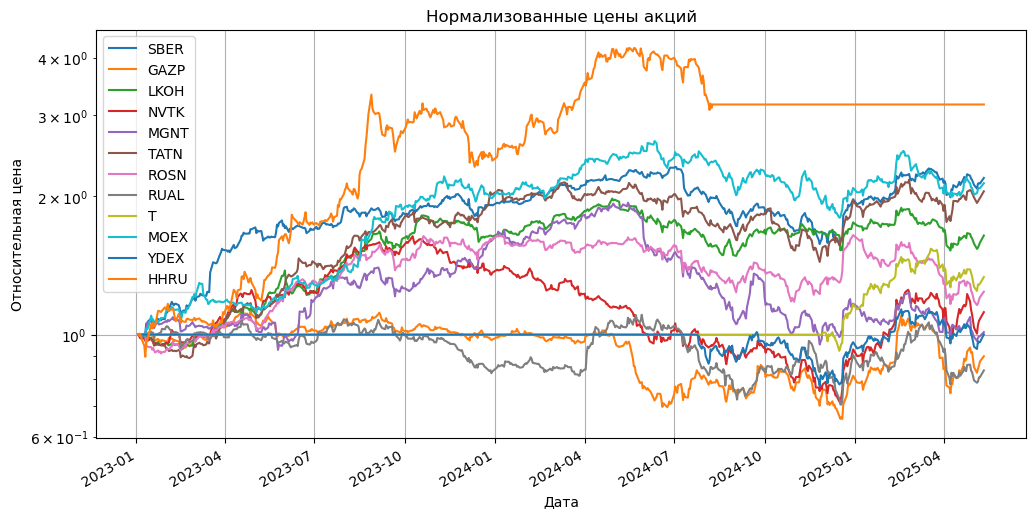

In [239]:
# Загружаем данные из функции выше
price_data = get_price_data(
    config["tickers"],
    config["start_date"],
    config["end_date"],
    config["source"],
    bond_tickers=config.get("bond_tickers")
)

# Проверка и очистка
if price_data.empty:
    raise ValueError("Ошибка: данные не загружены. Проверьте тикеры и даты.")

# Заполняем пропуски методом прямой подстановки
price_data = price_data.fillna(method="ffill").fillna(method="bfill") # заполнение пустоты предыдущим значением, оставшиеся пропуски просто удаляются

# Визуализация нормализованных цен
(price_data / price_data.iloc[0]).plot(figsize=(12, 6), title="Нормализованные цены акций", logy=True) # деление нужно чтобы все акции начинались с 1
plt.xlabel("Дата")
plt.ylabel("Относительная цена")
plt.grid(True)
plt.show()

In [240]:
# Смотрим что у нас в табличке лежит
print(price_data.tail())

              SBER    GAZP    LKOH    NVTK    MGNT   TATN    ROSN    RUAL  \
Date                                                                        
2025-05-05  294.64  135.09  6335.5  1077.8  4226.0  680.0  426.70  32.135   
2025-05-06  302.02  137.71  6373.5  1124.8  4288.5  685.0  430.25  32.320   
2025-05-07  302.79  139.90  6458.5  1149.0  4325.0  691.6  438.00  33.000   
2025-05-08  302.15  142.90  6535.0  1160.0  4327.0  696.8  443.90  33.045   
2025-05-12  310.81  146.73  6775.0  1200.6  4416.0  720.9  456.40  34.185   

                 T    MOEX    YDEX    HHRU  
Date                                        
2025-05-05  2946.2  194.15  3860.0  3908.0  
2025-05-06  3042.0  197.87  4013.0  3908.0  
2025-05-07  3038.0  199.29  3991.0  3908.0  
2025-05-08  3055.2  198.93  3993.5  3908.0  
2025-05-12  3158.4  204.00  4153.5  3908.0  


In [241]:
# Логарифмическая доходность
log_returns = np.log(price_data / price_data.shift(1)).dropna()
print(log_returns.head())

                SBER      GAZP      LKOH      NVTK      MGNT      TATN  \
Date                                                                     
2023-01-04 -0.002472 -0.006196 -0.001820 -0.011062  0.001947 -0.002278   
2023-01-05 -0.001132 -0.008094 -0.007071 -0.007380 -0.010006 -0.003999   
2023-01-06  0.000920  0.005568  0.000489 -0.000380 -0.001388  0.003429   
2023-01-09  0.007047  0.003756  0.005123 -0.000760  0.002428 -0.011186   
2023-01-10  0.002875 -0.003756 -0.007571 -0.011667  0.009767 -0.002889   

                ROSN      RUAL    T      MOEX  YDEX      HHRU  
Date                                                           
2023-01-04 -0.006132 -0.001958  0.0  0.002613   0.0  0.004850  
2023-01-05  0.004637 -0.006267  0.0 -0.000104   0.0 -0.006473  
2023-01-06 -0.000544  0.001355  0.0 -0.006283   0.0 -0.016367  
2023-01-09  0.001768  0.001845  0.0  0.003565   0.0 -0.037836  
2023-01-10 -0.003267 -0.003693  0.0 -0.006406   0.0 -0.055496  


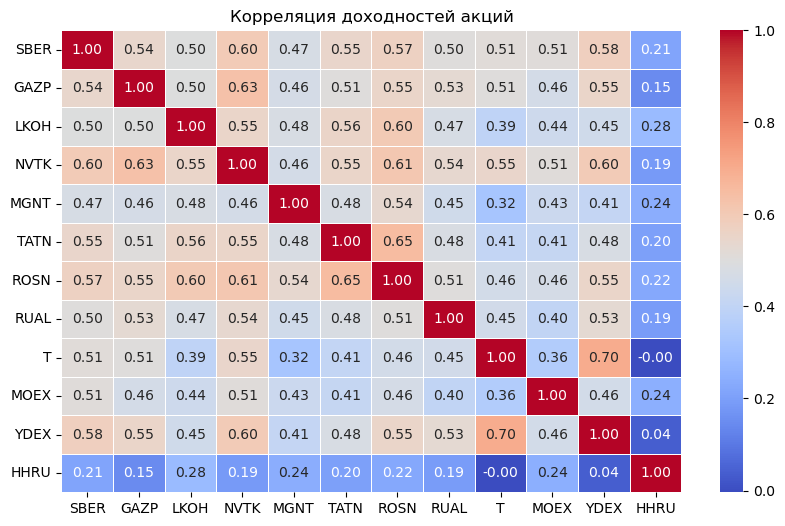

In [242]:
# Строим корреляционную матрицу доходностей
correlation_matrix = log_returns.corr()

# Визуализируем тепловую карту
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Корреляция доходностей акций")
plt.show()

In [243]:
# === Назначение весов по годам ===

# Настраиваемый словарь весов по годам
year_weights = {
    2021: 0.4,
    2022: 0.2,
    2023: 0.8,
    2024: 1.0,
}

# Функция для получения веса для каждой даты
def get_weights_for_dates(dates, year_weights_dict, default_weight=1.0):
    years = dates.year  # тут dates — это сразу DatetimeIndex
    weights = pd.Series([year_weights_dict.get(y, default_weight) for y in years], index=dates)
    return weights

# Применяем веса к логарифмическим доходностям
weights_series = get_weights_for_dates(log_returns.index, year_weights)

# Сохраняем в отдельную переменную на будущее
log_returns_weights = weights_series

# Выводим веса для каждого года
print("Веса по годам:")
for year, weight in year_weights.items():
    print(f"{year}: {weight}")


Веса по годам:
2021: 0.4
2022: 0.2
2023: 0.8
2024: 1.0


In [244]:
# 1. Получим список тикеров из конфига
tickers = config['tickers'] + config['bond_tickers']

# 2. Оставим только нужные активы в log_returns
log_returns_subset = log_returns[tickers]

# 3. Создадим бенчмарк — среднюю доходность портфеля
benchmark_returns = log_returns_subset.mean(axis=1)

# 4. Расчёт бета-коэффициентов
def compute_beta(returns_df, benchmark_returns):
    betas = {}
    for ticker in returns_df.columns:
        model = LinearRegression()
        model.fit(benchmark_returns.values.reshape(-1, 1), returns_df[ticker].values)
        betas[ticker] = model.coef_[0]  # это и есть β
    return pd.Series(betas)

betas_series = compute_beta(log_returns_subset, benchmark_returns)
print("Бета-коэффициенты:")
print(betas_series)

# 5. Преобразуем в словарь для маппинга в ML
betas_dict = betas_series.to_dict()

Бета-коэффициенты:
SBER    1.008903
GAZP    1.208647
LKOH    0.897565
NVTK    1.334956
MGNT    1.162086
TATN    1.024559
ROSN    1.091334
RUAL    1.168469
T       0.579509
MOEX    0.986664
YDEX    0.796441
HHRU    0.740866
dtype: float64


In [245]:
# === Взвешенная средняя доходность ===
mean_daily_returns = (log_returns.mul(log_returns_weights, axis=0)).sum() / log_returns_weights.sum()

# === Взвешенная ковариационная матрица ===
# Центрируем данные
centered_returns = log_returns - mean_daily_returns

# Применяем веса
weighted_centered = centered_returns.mul(np.sqrt(log_returns_weights), axis=0)

# Взвешенная ковариация
cov_matrix = (weighted_centered.T @ weighted_centered) / log_returns_weights.sum()

print("Взвешенная средняя доходность:")
print(mean_daily_returns)

print("Взвешенная ковариация:")
print(cov_matrix.head())

Взвешенная средняя доходность:
SBER    0.001197
GAZP   -0.000189
LKOH    0.000728
NVTK    0.000092
MGNT   -0.000150
TATN    0.001055
ROSN    0.000219
RUAL   -0.000260
T       0.000527
MOEX    0.001135
YDEX    0.000002
HHRU    0.001787
dtype: float64
Взвешенная ковариация:
          SBER      GAZP      LKOH      NVTK      MGNT      TATN      ROSN  \
SBER  0.000243  0.000167  0.000116  0.000190  0.000152  0.000145  0.000150   
GAZP  0.000167  0.000376  0.000142  0.000249  0.000182  0.000164  0.000179   
LKOH  0.000116  0.000142  0.000211  0.000162  0.000141  0.000136  0.000147   
NVTK  0.000190  0.000249  0.000162  0.000403  0.000187  0.000185  0.000205   
MGNT  0.000152  0.000182  0.000141  0.000187  0.000398  0.000160  0.000180   

          RUAL         T      MOEX      YDEX      HHRU  
SBER  0.000157  0.000095  0.000140  0.000128  0.000068  
GAZP  0.000201  0.000114  0.000158  0.000149  0.000060  
LKOH  0.000137  0.000068  0.000114  0.000093  0.000089  
NVTK  0.000214  0.000128  0.00

In [246]:
# Кол-во активов
num_assets = len(config["tickers"] + config["bond_tickers"])
print(f"Количество активов: {num_assets}")

Количество активов: 12


In [247]:
# Целевая функция — отрицательный коэффициент Шарпа
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate): # основные параметры для функции минимизации
    port_return = np.dot(weights, mean_returns) # ожидаемая средняя доходность портфеля
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) # стандартное отклонение доходности
    sharpe_ratio = (port_return - risk_free_rate / 252) / port_volatility # расчет коээфа Шарпа (деление на 252 нужно чтобы получить дневной процент)
    return -sharpe_ratio # отицательный коэфф Шарпа для максимизации

In [248]:
# Ограничения и условия
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # сумма весов = 1
bounds = tuple((0, 1) for _ in range(num_assets))  # веса от 0 до 1
initial_guess = num_assets * [1. / num_assets]  # равные веса

In [249]:
# Оптимизация
opt_result = minimize(
    neg_sharpe_ratio, # отрицательный коэфф Шарпа
    initial_guess, # равные веса активов
    args=(mean_daily_returns, cov_matrix, config["risk_free_rate"]), # аргументы для целевой функции где мы отрицательный коэф Шарпа искали
    method="SLSQP", # метод минимизации 
    bounds=bounds, # ограничения по весам активов
    constraints=constraints # ограничение по сумме весов
)

In [250]:
# Оптимальные веса
optimal_weights = opt_result.x

In [251]:
# Оптимальная дневная доходность и риск
port_return_daily = np.dot(optimal_weights, mean_daily_returns)
port_volatility_daily = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))

# Годовые метрики
port_return_annual = port_return_daily * 252
port_volatility_annual = port_volatility_daily * np.sqrt(252)

# Шарп
sharpe_ratio_annual = (port_return_annual - config["risk_free_rate"]) / port_volatility_annual

In [252]:
# Печатаем метрики
print("Оптимальные веса в портфеле:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.2%}")

print(f"\nДоходность портфеля: {port_return_daily:.4f} в день, {port_return_annual:.2%} в год")
print(f"Риск портфеля (волатильность): {port_volatility_daily:.4f} в день, {port_volatility_annual:.2%} в год")
print(f"Коэффициент Шарпа (годовой): {sharpe_ratio_annual:.2f}")

Оптимальные веса в портфеле:
SBER: 36.94%
GAZP: 0.00%
LKOH: 0.00%
NVTK: 0.00%
MGNT: 0.00%
TATN: 2.39%
ROSN: 0.00%
RUAL: 0.00%
T: 0.00%
MOEX: 8.21%
YDEX: 0.00%
HHRU: 52.46%

Доходность портфеля: 0.0015 в день, 37.76% в год
Риск портфеля (волатильность): 0.0145 в день, 23.03% в год
Коэффициент Шарпа (годовой): 0.99


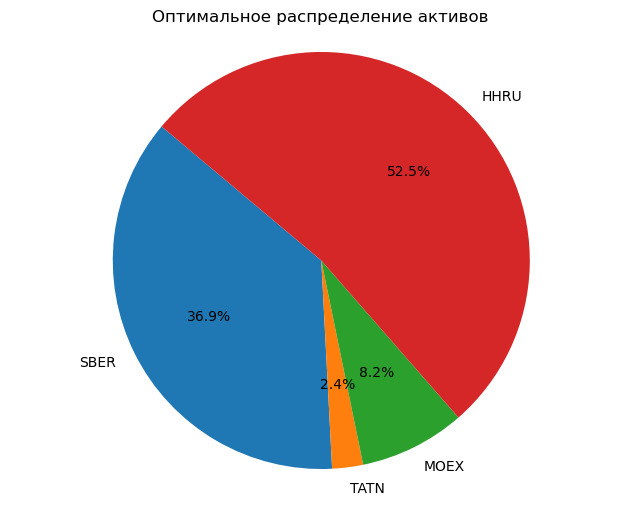

In [253]:
# Исключаем активы с нулевым весом
non_zero_weights = [(ticker, weight) for ticker, weight in zip(tickers, optimal_weights) if weight > 1e-6]  # Убираем веса, близкие к нулю

# Проверяем, есть ли активы с ненулевыми весами
if non_zero_weights:
    # Разделяем тикеры и веса
    filtered_tickers, filtered_weights = zip(*non_zero_weights)

    # Построение диаграммы
    plt.figure(figsize=(8, 6))
    plt.pie(filtered_weights, labels=filtered_tickers, autopct="%1.1f%%", startangle=140)
    plt.title("Оптимальное распределение активов")
    plt.axis("equal")
    plt.show()
else:
    print("Все активы имеют нулевые веса. Нечего отображать.")

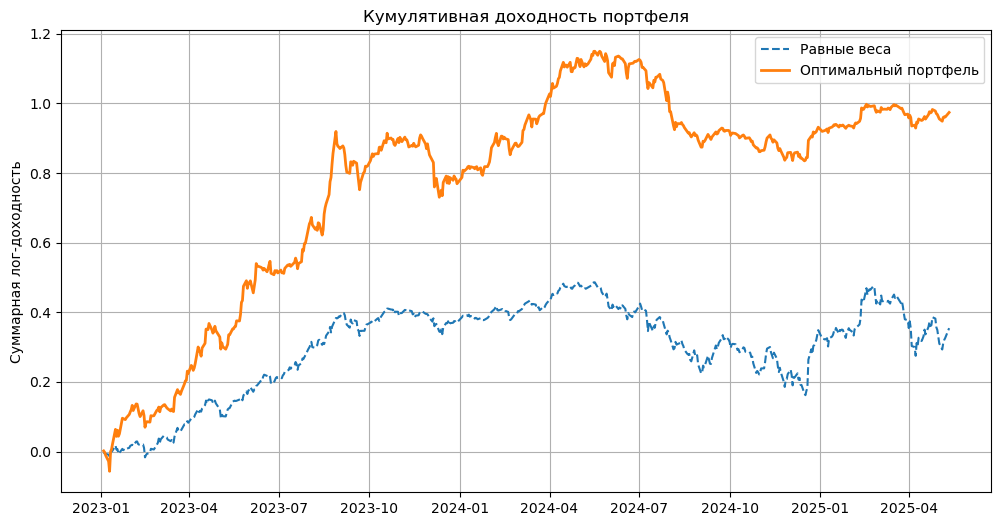

In [254]:
# Доходность портфеля с равными и оптимальными весами
equal_weights = np.repeat(1/num_assets, num_assets)

# Капитал под управлением
initial_capital = 100

# Кумулятивная доходность
portfolio_equal = (log_returns @ equal_weights).cumsum()
portfolio_optimal = (log_returns @ optimal_weights).cumsum()

plt.figure(figsize=(12, 6))
plt.plot(portfolio_equal, label="Равные веса", linestyle="--")
plt.plot(portfolio_optimal, label="Оптимальный портфель", linewidth=2)
plt.title("Кумулятивная доходность портфеля")
plt.ylabel("Суммарная лог-доходность")
plt.legend()
plt.grid(True)
plt.show()

In [255]:
# --- Value of Information на основе кумулятивной лог-доходности ---

# 1. Годовая доходность для обоих портфелей
port_return_daily_equal = np.dot(equal_weights, mean_daily_returns)
annual_return_equal = port_return_daily_equal * 252

annual_return_optimal = port_return_annual 

# 2. Ценность информации = разница между доходностями
value_of_information = annual_return_optimal - annual_return_equal

# 3. Вывод результатов
print(f"Годовая доходность (оптимальное распределение): {annual_return_optimal:.2%}")
print(f"Годовая доходность (равномерное распределение):     {annual_return_equal:.2%}")
print(f"Ценность информации:                 {value_of_information:.2%}")

Годовая доходность (оптимальное распределение): 37.76%
Годовая доходность (равномерное распределение):     12.90%
Ценность информации:                 24.86%


Блок с прогнозом

In [256]:
n_lags = 30  # Количество лагов (дней), используемых для построения признаков
horizon = 30  # Горизонт прогнозирования (количество дней вперед)
expected_returns_ml = {}  # Словарь для хранения ожидаемых доходностей

for ticker in price_data.columns:
    df = price_data[ticker].copy().reset_index()  # Преобразуем индекс в столбец
    df = df.rename(columns={"index": "Date"})  # Убедимся, что столбец называется "Date"

    # Создаем лаги
    for lag in range(1, n_lags + 1):
        df[f"lag_{lag}"] = df[ticker].shift(lag)

    # Целевая переменная — цена на следующий день
    df["target"] = df[ticker].shift(-1)
    df_model = df.dropna().reset_index(drop=True)

    # Проверяем, достаточно ли данных для обучения
    if len(df_model) < 100:
        print(f"Недостаточно данных для {ticker}, пропускаем.")
        continue

    # Сохраняем оригинальные индексы
    original_indices = df_model["Date"]  # Убедитесь, что "Date" существует

    # Разделяем данные на признаки и целевую переменную
    X = df_model[[f"lag_{i}" for i in range(1, n_lags + 1)]].copy()
    y = df_model["target"]

    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
        X, y, original_indices, shuffle=False, test_size=0.2
    )

    # Отбор весов по оригинальным индексам
    weights_train = log_returns_weights.loc[indices_train]

    # Обучение модели с весами
    
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train, y_train, sample_weight=weights_train)

    # Последние данные для предсказания
    latest_data = X.iloc[[-1]]

    # Прогноз на 60 дней вперед
    future_predictions = []
    for day in range(horizon):
        predicted_price = model.predict(latest_data)[0]
        future_predictions.append(predicted_price)

        # Обновляем данные для следующего прогноза
        new_row = latest_data.to_numpy().flatten().tolist()[1:] + [predicted_price]
        columns = [f"lag_{i}" for i in range(1, n_lags + 1)]  # Обновляем список столбцов
        latest_data = pd.DataFrame([new_row], columns=columns)

    # Сохраняем прогнозы
    predictions[ticker] = future_predictions

for ticker in price_data.columns:
    # Подготовка исходных данных
    df = price_data[ticker].copy().reset_index()  # Преобразуем индекс в столбец
    df = df.rename(columns={"index": "ds", ticker: "y"})  # Переименовываем столбцы
    df = df.dropna()

    # Присоединяем веса
    df["weight"] = df["ds"].map(log_returns_weights).fillna(1.0)

    if len(df) < 100:
        print(f"Недостаточно данных для {ticker}, пропускаем.")
        continue

    # Эмуляция sample_weight: дублируем строки согласно весу (с округлением)
    df["dup_count"] = (df["weight"] * 10).round().astype(int).clip(lower=1)
    df_weighted = df.loc[df.index.repeat(df["dup_count"])][["ds", "y"]]

    # Обучение модели
    model = Prophet()
    model.fit(df_weighted)

    # Прогноз
    future = model.make_future_dataframe(periods=horizon)
    forecast = model.predict(future)

    # Сохраняем прогноз
    predicted_values = forecast[["ds", "yhat"]].tail(horizon)["yhat"].values
    predictions[ticker] = predicted_values

In [257]:
predictions = {} # Словарь для хранения прогнозных цен

if config["model"] == "XGBRegressor":
    for ticker in price_data.columns:
        # Подготовка данных
        df = price_data[ticker].copy().reset_index()  # Преобразуем индекс в столбец
        df = df.rename(columns={"index": "Date"})  # Убедимся, что столбец называется "Date"

        # Создаем лаги
        for lag in range(1, n_lags + 1):
            df[f"lag_{lag}"] = df[ticker].shift(lag)

        # Целевая переменная — цена на следующий день
        df["target"] = df[ticker].shift(-1)
        df_model = df.dropna().reset_index(drop=True)

        # Проверяем, достаточно ли данных для обучения
        if len(df_model) < 100:
            print(f"Недостаточно данных для {ticker}, пропускаем.")
            continue

        # Сохраняем оригинальные индексы
        original_indices = df_model["Date"]

        # Разделяем данные на признаки и целевую переменную
        X = df_model[[f"lag_{i}" for i in range(1, n_lags + 1)]].copy()
        y = df_model["target"]

        # Разделяем данные на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
            X, y, original_indices, shuffle=False, test_size=0.2
        )

        # Отбор весов по оригинальным индексам
        weights_train = log_returns_weights.loc[indices_train]

        # Обучение модели с весами
        model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
        model.fit(X_train, y_train, sample_weight=weights_train)

        # Последние данные для предсказания
        latest_data = X.iloc[[-1]]

        # Прогноз на horizon дней вперед
        future_predictions = []
        for day in range(horizon):
            predicted_price = model.predict(latest_data)[0]
            future_predictions.append(predicted_price)

            # Обновляем данные для следующего прогноза
            new_row = latest_data.to_numpy().flatten().tolist()[1:] + [predicted_price]
            columns = [f"lag_{i}" for i in range(1, n_lags + 1)]
            latest_data = pd.DataFrame([new_row], columns=columns)

        # Сохраняем прогнозы
        predictions[ticker] = future_predictions

elif config["model"] == "Prophet":
    for ticker in price_data.columns:
        # Подготовка исходных данных
        df = price_data[ticker].copy().reset_index()  # Преобразуем индекс в столбец
        df = df.rename(columns={"index": "Date", ticker: "y"}).dropna()  # Переименовываем столбцы

        # Присоединяем веса
        df["weight"] = df["Date"].map(log_returns_weights).fillna(1.0)

        if len(df) < 100:
            print(f"Недостаточно данных для {ticker}, пропускаем.")
            continue

        # Эмуляция sample_weight: дублируем строки согласно весу (с округлением)
        df["dup_count"] = (df["weight"] * 10).round().astype(int).clip(lower=1)
        df_weighted = df.loc[df.index.repeat(df["dup_count"])][["Date", "y"]]

        # Обучение модели
        model = Prophet()
        model.fit(df_weighted.rename(columns={"Date": "ds"}))  # Prophet ожидает столбец 'ds' для дат

        # Прогноз
        future = model.make_future_dataframe(periods=horizon)
        forecast = model.predict(future)

        # Сохраняем прогноз
        predicted_values = forecast[["ds", "yhat"]].tail(horizon)["yhat"].values
        predictions[ticker] = predicted_values

In [258]:
# Создаем DataFrame с прогнозными ценами закрытия
price_data_fcst = pd.DataFrame(predictions, index=pd.date_range(start=price_data.index[-1] + pd.Timedelta(days=1), periods=horizon))
price_data_fcst.index.name = "Date"

# Выводим DataFrame с прогнозами
print("Прогнозные цены закрытия:")
print(price_data_fcst.head())

Прогнозные цены закрытия:
                  SBER        GAZP         LKOH         NVTK         MGNT  \
Date                                                                        
2025-05-13  309.849945  136.346344  6369.694824  1142.612549  4362.128906   
2025-05-14  306.686096  133.269348  6351.996094  1107.598022  4374.960449   
2025-05-15  297.636047  130.972946  6395.638184  1084.098511  4397.674805   
2025-05-16  303.256805  133.324722  6481.655762  1109.263794  4382.425781   
2025-05-17  309.231598  136.833176  6761.656738  1193.196167  4524.947266   

                  TATN        ROSN       RUAL       T        MOEX  \
Date                                                                
2025-05-13  691.987305  437.862701  31.667768  2367.0  196.326309   
2025-05-14  694.736084  440.193756  30.993738  2367.0  194.997421   
2025-05-15  695.023682  443.838959  31.330353  2367.0  192.760864   
2025-05-16  700.993591  447.835754  33.550346  2367.0  194.075867   
2025-05-17  711.2370

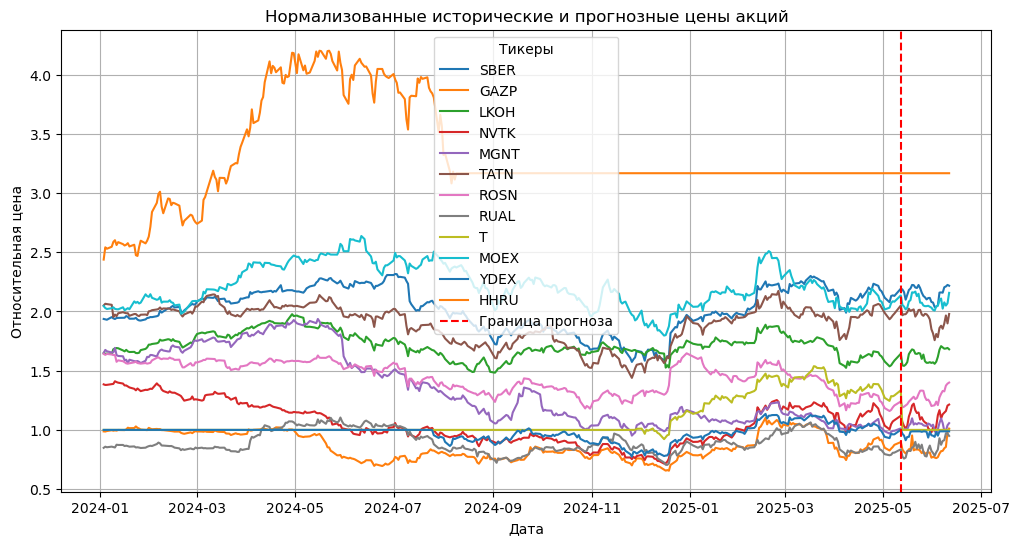

In [259]:
# Объединение исторических и прогнозных данных
combined_data = pd.concat([price_data, price_data_fcst])

# Нормализация объединенных данных
normalized_combined_data = combined_data / combined_data.iloc[0]

# Фильтрация данных, начиная с 2024 года
normalized_combined_data = normalized_combined_data.loc["2024-01-01":]

# Визуализация нормализованных данных
plt.figure(figsize=(12, 6))

for ticker in normalized_combined_data.columns:
    # Полная линия для каждого тикера
    plt.plot(
        normalized_combined_data.index, 
        normalized_combined_data[ticker], 
        label=ticker
    )

# Добавляем вертикальную линию для разделения истории и прогноза
plt.axvline(x=price_data.index[-1], color="red", linestyle="--", label="Граница прогноза")

plt.title("Нормализованные исторические и прогнозные цены акций")
plt.xlabel("Дата")
plt.ylabel("Относительная цена")
plt.legend(title="Тикеры")
plt.grid(True)
plt.show()

Блок с оптимизацией портфеля с учетом прогнозных значений

In [260]:
# Смотрим что у нас в табличке лежит
print(combined_data.tail())

                  SBER        GAZP         LKOH         NVTK         MGNT  \
Date                                                                        
2025-06-07  305.995667  134.586868  6995.538574  1213.990479  4610.421387   
2025-06-08  312.531921  138.127762  6950.428711  1229.069824  4326.891113   
2025-06-09  313.473450  140.038544  6956.944336  1243.737549  4336.010742   
2025-06-10  315.290436  160.364487  6976.582520  1292.730225  4531.277344   
2025-06-11  314.327393  165.301483  6928.752930  1301.951904  4608.713867   

                  TATN        ROSN       RUAL       T        MOEX  \
Date                                                                
2025-06-07  651.794006  489.027283  37.075500  2367.0  193.349457   
2025-06-08  667.449524  487.787628  37.353855  2367.0  198.418564   
2025-06-09  691.307373  505.665680  39.746693  2367.0  195.838043   
2025-06-10  667.651733  511.758881  39.642155  2367.0  197.670517   
2025-06-11  695.718506  515.104065  38.823009 

In [261]:
# 2. Рассчитываем логарифмическую доходность на основе объединенных данных
log_returns_fcst = np.log(combined_data / combined_data.shift(1)).dropna()
print(log_returns_fcst.tail())


                SBER      GAZP      LKOH      NVTK      MGNT      TATN  \
Date                                                                     
2025-06-07 -0.001164  0.003113 -0.006222  0.032370 -0.036537 -0.013574   
2025-06-08  0.021136  0.025969 -0.006469  0.012345 -0.063470  0.023735   
2025-06-09  0.003008  0.013739  0.000937  0.011863  0.002105  0.035121   
2025-06-10  0.005780  0.135532  0.002819  0.038635  0.044049 -0.034818   
2025-06-11 -0.003059  0.030322 -0.006879  0.007108  0.016945  0.041178   

                ROSN      RUAL    T      MOEX      YDEX  HHRU  
Date                                                           
2025-06-07  0.018493  0.036226  0.0 -0.041395  0.000141   0.0  
2025-06-08 -0.002538  0.007480  0.0  0.025880  0.000333   0.0  
2025-06-09  0.035996  0.062091  0.0 -0.013091 -0.000206   0.0  
2025-06-10  0.011978 -0.002634  0.0  0.009314  0.000211   0.0  
2025-06-11  0.006515 -0.020880  0.0  0.041712 -0.000789   0.0  


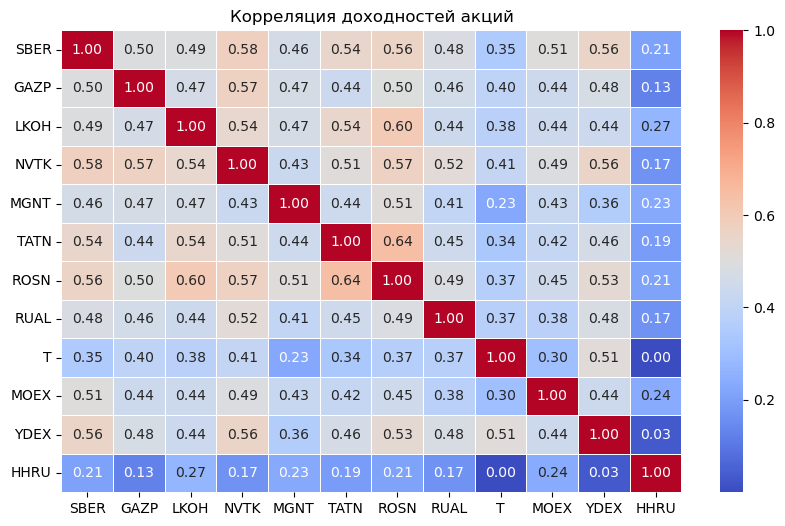

In [262]:
# Строим корреляционную матрицу доходностей
correlation_matrix = log_returns_fcst.corr()

# Визуализируем тепловую карту
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Корреляция доходностей акций")
plt.show()

In [263]:
# 1. Получим список тикеров из конфига
tickers = config['tickers'] + config['bond_tickers']

# 2. Оставим только нужные активы в log_returns
log_returns_subset_fcst = log_returns_fcst[tickers]

# 3. Создадим бенчмарк — среднюю доходность портфеля
benchmark_returns_fcst = log_returns_subset_fcst.mean(axis=1)

# 4. Расчёт бета-коэффициентов
def compute_beta_fcst(returns_df_fcst, benchmark_returns_fcst):
    betas_fcst = {}
    for ticker in returns_df_fcst.columns:
        model_fcst = LinearRegression()
        model_fcst.fit(benchmark_returns_fcst.values.reshape(-1, 1), returns_df_fcst[ticker].values)
        betas_fcst[ticker] = model_fcst.coef_[0]  # это и есть β
    return pd.Series(betas_fcst)

betas_series_fcst = compute_beta_fcst(log_returns_subset_fcst, benchmark_returns_fcst)
print("Бета-коэффициенты:")
print(betas_series_fcst)

Бета-коэффициенты:
SBER    0.963680
GAZP    1.276165
LKOH    0.892774
NVTK    1.341132
MGNT    1.124573
TATN    0.994411
ROSN    1.059357
RUAL    1.229048
T       0.709744
MOEX    0.958934
YDEX    0.783308
HHRU    0.666873
dtype: float64


In [264]:
# 3. Рассчитываем среднюю логарифмическую доходность и ковариационную матрицу
mean_daily_returns_fcst = log_returns_fcst.mean()  # Средняя логарифмическая доходность по каждому тикеру
cov_matrix_fcst = log_returns_fcst.cov()  # Ковариационная матрица логарифмических доходностей

print("Взвешенная средняя доходность:")
print(mean_daily_returns_fcst)

print("Взвешенная ковариация:")
print(cov_matrix_fcst)

Взвешенная средняя доходность:
SBER    1.267768e-03
GAZP    1.725425e-05
LKOH    8.263973e-04
NVTK    3.085653e-04
MGNT    8.815621e-05
TATN    1.086705e-03
ROSN    5.352709e-04
RUAL   -8.298880e-05
T       8.839355e-19
MOEX    1.223987e-03
YDEX   -2.004574e-05
HHRU    1.835574e-03
dtype: float64
Взвешенная ковариация:
          SBER      GAZP      LKOH      NVTK      MGNT      TATN      ROSN  \
SBER  0.000242  0.000165  0.000113  0.000188  0.000146  0.000142  0.000144   
GAZP  0.000165  0.000459  0.000148  0.000255  0.000204  0.000157  0.000177   
LKOH  0.000113  0.000148  0.000219  0.000167  0.000141  0.000135  0.000148   
NVTK  0.000188  0.000255  0.000167  0.000436  0.000182  0.000179  0.000197   
MGNT  0.000146  0.000204  0.000141  0.000182  0.000409  0.000150  0.000170   
TATN  0.000142  0.000157  0.000135  0.000179  0.000150  0.000281  0.000179   
ROSN  0.000144  0.000177  0.000148  0.000197  0.000170  0.000179  0.000274   
RUAL  0.000160  0.000209  0.000139  0.000231  0.000176 

In [265]:
# 4. Оптимизация портфеля через коэффициент Шарпа
def neg_sharpe_ratio_fcst(weights, expected_log_returns_fcst, cov_matrix_fcst, risk_free_rate):
    port_return_fcst = np.dot(weights, expected_log_returns_fcst)
    port_volatility_fcst = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_fcst, weights)))
    sharpe_ratio_fcst = (port_return_fcst - risk_free_rate / 252) / port_volatility_fcst  # Отрицательный Шарп для минимизации
    return -sharpe_ratio_fcst  # Отрицательный коэффициент Шарпа для максимизации

In [266]:
# 5. Ограничения и условия
constraints_fcst = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # сумма весов = 1
bounds_fcst = tuple((0, 1) for _ in range(num_assets))  # веса от 0.1 до 1
initial_guess_fcst = num_assets * [1. / num_assets]  # равные веса

In [267]:
# Оптимизация
opt_result_fcst = minimize(
    neg_sharpe_ratio_fcst, # отрицательный коэфф Шарпа
    initial_guess_fcst, # равные веса активов
    args=(mean_daily_returns_fcst, cov_matrix_fcst, config["risk_free_rate"]), # аргументы для целевой функции где мы отрицательный коэф Шарпа искали
    method="SLSQP", # метод минимизации 
    bounds=bounds, # ограничения по весам активов
    constraints=constraints # ограничение по сумме весов
)

In [268]:
# Оптимальные веса
optimal_weights_fcst = opt_result_fcst.x

In [269]:
# Оптимальная дневная доходность и риск
port_return_daily_fcst = np.dot(optimal_weights_fcst, mean_daily_returns_fcst)
port_volatility_daily_fcst = np.sqrt(np.dot(optimal_weights_fcst.T, np.dot(cov_matrix_fcst, optimal_weights_fcst)))

# Годовые метрики
port_return_annual_fcst = port_return_daily_fcst * 252
port_volatility_annual_fcst = port_volatility_daily_fcst * np.sqrt(252)

# Шарп
sharpe_ratio_annual_fcst = (port_return_annual_fcst - config["risk_free_rate"]) / port_volatility_annual_fcst

In [270]:
# Печатаем метрики
print("Оптимальные веса в портфеле:")
for ticker, weight in zip(tickers, optimal_weights_fcst):
    print(f"{ticker}: {weight:.2%}")

print(f"\nДоходность портфеля: {port_return_daily_fcst:.4f} в день, {port_return_annual_fcst:.2%} в год")
print(f"Риск портфеля (волатильность): {port_volatility_daily_fcst:.4f} в день, {port_volatility_annual_fcst:.2%} в год")
print(f"Коэффициент Шарпа (годовой): {sharpe_ratio_annual_fcst:.2f}")

Оптимальные веса в портфеле:
SBER: 37.71%
GAZP: 0.00%
LKOH: 0.00%
NVTK: 0.00%
MGNT: 0.00%
TATN: 0.52%
ROSN: 0.00%
RUAL: 0.00%
T: 0.00%
MOEX: 13.26%
YDEX: 0.00%
HHRU: 48.51%

Доходность портфеля: 0.0015 в день, 38.72% в год
Риск портфеля (волатильность): 0.0142 в день, 22.56% в год
Коэффициент Шарпа (годовой): 1.05


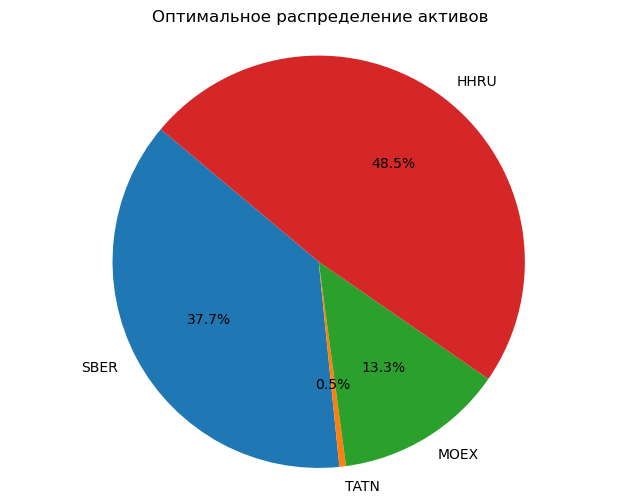

In [271]:
# Исключаем активы с нулевым весом
non_zero_weights_fcst = [(ticker, weight) for ticker, weight in zip(tickers, optimal_weights_fcst) if weight > 1e-6]  # Убираем веса, близкие к нулю

# Проверяем, есть ли активы с ненулевыми весами
if non_zero_weights_fcst:
    # Разделяем тикеры и веса
    filtered_tickers_fcst, filtered_weights_fcst = zip(*non_zero_weights_fcst)

    # Построение диаграммы
    plt.figure(figsize=(8, 6))
    plt.pie(filtered_weights_fcst, labels=filtered_tickers_fcst, autopct="%1.1f%%", startangle=140)
    plt.title("Оптимальное распределение активов")
    plt.axis("equal")
    plt.show()
else:
    print("Все активы имеют нулевые веса. Нечего отображать.")

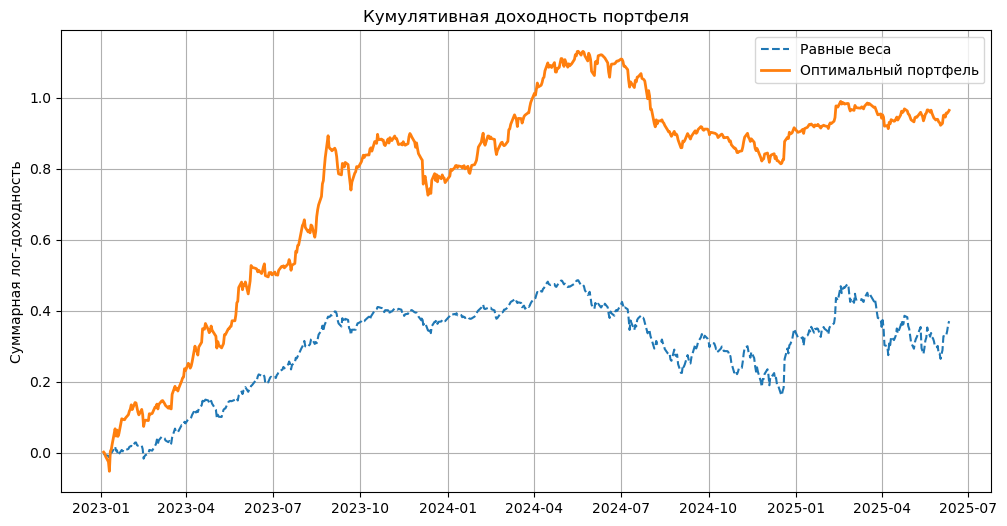

In [272]:
# Доходность портфеля с равными и оптимальными весами
equal_weights_fcst = np.repeat(1/num_assets, num_assets)

# Капитал под управлением
initial_capital = 100

# Кумулятивная доходность
portfolio_equal_fcst = (log_returns_fcst @ equal_weights_fcst).cumsum()
portfolio_optimal_fcst = (log_returns_fcst @ optimal_weights_fcst).cumsum()

plt.figure(figsize=(12, 6))
plt.plot(portfolio_equal_fcst, label="Равные веса", linestyle="--")
plt.plot(portfolio_optimal_fcst, label="Оптимальный портфель", linewidth=2)
plt.title("Кумулятивная доходность портфеля")
plt.ylabel("Суммарная лог-доходность")
plt.legend()
plt.grid(True)
plt.show()

In [273]:
# --- Value of Information на основе кумулятивной лог-доходности ---

# 1. Годовая доходность для обоих портфелей
port_return_daily_equal_fcst = np.dot(equal_weights_fcst, mean_daily_returns_fcst)
annual_return_equal_fcst = port_return_daily_equal_fcst * 252

annual_return_optimal_fcst = port_return_annual_fcst 

# 2. Ценность информации = разница между доходностями
value_of_information_fcst = annual_return_optimal_fcst - annual_return_equal_fcst

# 3. Вывод результатов
print(f"Годовая доходность (оптимальное распределение): {annual_return_optimal_fcst:.2%}")
print(f"Годовая доходность (равномерное распределение):     {annual_return_equal_fcst:.2%}")
print(f"Ценность информации:                 {value_of_information_fcst:.2%}")

Годовая доходность (оптимальное распределение): 38.72%
Годовая доходность (равномерное распределение):     14.88%
Ценность информации:                 23.84%
